<a href="https://colab.research.google.com/github/schmcklr/skill_extractor/blob/main/skill_extractor_analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Load input data & define functions


1.1 Defining function for stopword removal 


*   uses nltk library, extended by custom stopwords




In [3]:
from nltk import word_tokenize, pos_tag, ne_chunk

# Defining other stop words
other_stop_words = ['genetics','financial', 'go', 'public', 'transport']

# Function for removing stopwords from dataframe
def remove_stopwords(df_column):
    df_column = df_column.apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))
    return df_column

1.2 Defining function for topic visualization
*   uses pyLDAvis to display gensim topic models

In [4]:
# Needed for topic visualization
!pip install --upgrade pyldavis        
import pyLDAvis
import pyLDAvis.gensim_models
import webbrowser  

# Function which allows visualization of topic modeling
def visualization_with_vis(lda_model, corpus, dictionary, name):
  vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds='mmds')
  pyLDAvis.enable_notebook()
  pyLDAvis.display(vis)
  pyLDAvis.save_html(vis, name + '.html')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2. Preprocessing data


*  filtering job advertisements for "bpm" or "process" in the job description
*  stopwords removing



2.1 Filtering and stopword removal




In [5]:
# Preprocessing data
import pandas as pd

# User info
print('Loading job advertisement data...')

# Fetching raw data (preprocessed data)
#workbook = 'https://github.com/schmcklr/skill_analyser/blob/main/job_data/job_data_preprocessed.xlsx?raw=true'
# workbook with cut job description
#workbook = 'https://github.com/schmcklr/skill_analyser/blob/main/job_data/job_data_preprocessed_description_cut.xlsx?raw=true'
workbook = 'https://github.com/schmcklr/skill_analyser/blob/main/job_data/job_data_preprocessed_description_filtered.xlsx?raw=true'
#workbook = 'https://github.com/schmcklr/skill_analyser/blob/main/job_data/job_data_preprocessed_description_filtered_for_testing.xlsx?raw=true'

# Import of tabs
job_data = pd.read_excel(workbook, sheet_name="Sheet1")

# User info
print('Preprocessing job advertisements (' + str(len(job_data['description'])) + ')...')

# Specifies job keywords
jobKeywords = ["bpm", "process"]

# Filter dataframe by keywords in column 'description' (ignores case)
job_data = job_data[job_data['rawDescription'].str.contains('|'.join(jobKeywords), case=False)]

# Remove duplicates
job_data.drop_duplicates(subset=['title', 'description'], keep='first', inplace=False)

# Removing stopwords from dataframe (currently not needed, because of skill extraction)
#job_data['descriptionTokenized'] = remove_stopwords(job_data['descriptionTokenized'])

# Copying the 'descriptionTokenized' column to also have the complete text
job_data['descriptionTokenizedComplete'] = job_data['descriptionTokenized']


# using the with create_skill_list created dictionary to extract skills from job adds
#job_data['descriptionTokenized'] = extract_skills(job_data['descriptionTokenized'])

print('Preprocessing successfull! ' + str(len(job_data['description'])) + ' Job advertisements are left.')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading job advertisement data...
Preprocessing job advertisements (2694)...
Preprocessing successfull! 2654 Job advertisements are left.


2.2.1 Connecting to API (emsicloud)




In [6]:
import requests
import pandas as pd
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
!pip install spacy
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

# Lemmatize the skills
lemmatizer = WordNetLemmatizer()

# Requesting access token
url = "https://auth.emsicloud.com/connect/token"
payload = "client_id=lwtnyxiuohd90aqc&client_secret=ZqV4d9LQ&grant_type=client_credentials&scope=emsi_open"
headers = {'Content-Type': 'application/x-www-form-urlencoded'}
response = requests.request("POST", url, data=payload, headers=headers)
url = "https://emsiservices.com/skills/versions/latest/skills"

# Storing access token
access_token = response.json()["access_token"]

# Requesting skill list
querystring = {"fields": "name,type,category,subcategory", "limit": "100000"}
headers = {'Authorization': 'Bearer ' + access_token}
response = requests.request("GET", url, headers=headers, params=querystring)
data = response.json()

# Initialise skill array
skills = []

# Initialise skill dict
skills_dict = {}

# Add skills to skills_dict
for entry in data["data"]:
    if entry['category'] is None:
        category = 'other'
    elif entry['category']["name"] == 'NULL':
        category = 'other'
    else:
        category = entry['category']["name"]
    if entry['subcategory'] is None:
        subcategory = 'other'
    elif entry['subcategory']["name"] == 'NULL':
        subcategory = 'other'
    else:
        subcategory = entry['subcategory']["name"]
    skills_dict[lemmatizer.lemmatize(entry["name"].lower().replace(' ', '_').replace('(','').replace(')','').replace('.',''))] = {
        'name':  lemmatizer.lemmatize(entry["name"].lower().replace(' ', '_').replace('(','').replace(')','').replace('.','')),
        'category': category,
        'subcategory': subcategory
    }

# Add skills to array
for entry in data["data"]:
    skills.append(lemmatizer.lemmatize(entry["name"].lower()))

# Store categories & sub categories
categories = {}
sub_categories = {}

for skill in skills_dict.values():
    category = skill['category']
    if category not in categories:
        categories[category] = []
    categories[category].append(skill['name'])

for skill in skills_dict.values():
    subcategory = skill['subcategory']
    if subcategory not in sub_categories:
        sub_categories[subcategory] = []
    sub_categories[subcategory].append(skill['name'])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


2.2.2 Import of O*net technology skills

In [7]:
# Import technology skills raw data
onet_skills_workbook = 'https://github.com/schmcklr/skill_analyser/blob/main/job_data/Technology%20Skills.xlsx?raw=true'

# Import of tabs
onet_skills = pd.read_excel(onet_skills_workbook, sheet_name="Technology Skills")

# Convert to list
onet_skills = onet_skills['Example'].str.lower().tolist()

# Append to skill list
skills += onet_skills

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.3 Creating skill list

*   Loading skills from API
*   Adding own skill terms

In [8]:
from re import U
# Creating own skill list
other_skills = ['python', 'c++', 'c', 'r', 'java', 'hadoop', 'scala', 'flask', 'pandas', 'spark', 'scikit-learn',
                'numpy', 'php', 'sql', 'mysql', 'css', 'mongdb', 'nltk', 'fastai', 'keras', 'pytorch', 'tensorflow',
                'ruby', 'javascript', 'django', 'react', 'reactjs', 'ai', 'ui', 'tableau', 'crm', 'modeling',
                'bpm', 'vision', 'communication', 'analysis', 'design',
                'governance', 'police', 'simulation', 'automation', 'kpi', 'erp', 'statistic', 'sap', 'german', 'english', 'kafka', 'api', 'rest', 'database', 'metrics', 'autonomy']

# Creating composed skills (needed for lemmatization that words considered as one word)
composite_skills = ['process_modeling', 'application_development', 'change_techniques', 'business_case',
                    'business_process_improvement', 'business_process', 'team_player']

# Custom list for BPM Gartner skill set
gartner_skill_set = ['business_case', 'project_management', 'organizational', 'communication',
                     'change_management', 'process_discovery', 'process_modeling', 'governance',
                     'performance_management', 'methodology_toolbox',
                     'architecture', 'bpmn', 'bpm', 'agile_development', 'optimization', 'user_experience', 'ui'
                     ]

# List with skill synonyms                   
skill_synonyms = {
    'artificial_intelligence' : ['ai', 'artifical_intelligence'],
    'user_interface': ['ui'], 
    'business_process_management': ['bpmn', 'bpm'], 
    'english_language': ['english'],
    'german_language': ['german']
}

# Extending skill list fetched from Api
skills += other_skills
skills += composite_skills
skills += gartner_skill_set

############################################TESTING############################
'''
new_skills_list = []

for skill in skills:
    skill_words = skill.split(' ') # splitting the skill terms into tokens
    for i in range(1, len(skill_words)):
        new_skills_list.append(' '.join(skill_words[:i+1])) # adding bigrams and trigrams
    new_skills_list.extend(skill_words) # Hinzufügen der einzelnen Wörter
skills.extend(new_skills_list)
'''
################################################################################

# Replace the blanks with '_' to recognise compound skills 
for i in range(len(skills)):
    skills[i] = skills[i].replace(" ", "_")

# Convert to set to remove duplicates and for faster access
skills = set(skills)

# Create filtered skill set to match recognized skills with emsi skill list
filtered_skills = set()
for skill in skills:
    if "_(" in skill:
        filtered_skills.add(skill)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.4 Define function for skill extraction

In [9]:
# Function for skill extraction
def extract_skills(df_column):
  df_column = df_column.apply(lambda x: " ".join(x for x in x.split() if x in skills))
  return df_column

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.5 Group data by year and visualize

In [10]:
# Group the DataFrame by year
grouped = job_data.groupby(job_data['created_at'].dt.year)

# Create a dictionary to store the new DataFrames
year_dfs = {}

# Split the groups into separate DataFrames and store them in the dictionary
for year, group in grouped:
    year_dfs[year] = group.copy()

# Number of jobs ads per year
number_of_ads_per_year = {}
for year in year_dfs:
  number_of_ads_per_year[year] = len(year_dfs[year]['descriptionTokenizedComplete'])
print(number_of_ads_per_year)

{2015: 122, 2016: 37, 2017: 35, 2018: 240, 2019: 647, 2020: 694, 2021: 704, 2022: 175}


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Visualization of job postings by year

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1000x500 with 0 Axes>

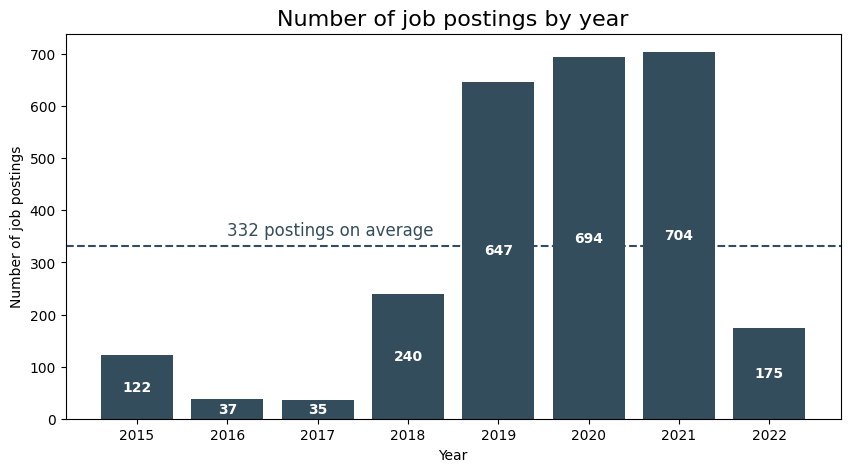

In [11]:
import matplotlib.pyplot as plt

# Set color
color = '#334d5c'

# Sort the data by years
sorted_data = sorted(number_of_ads_per_year.items())

# Creating a figure object
fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(figsize=(10,5))

# Creating bar plot with job data
years = [x[0] for x in sorted_data]
counts = [x[1] for x in sorted_data]
bars = ax.bar(years, counts, color=color)

# Set lable for number of postings
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height/2, int(height),
            ha='center', va='center', color='white', fontweight='bold', fontsize=10)

# Set axis, labels and title
ax.set_xlabel('Year', fontsize=10)
ax.set_ylabel('Number of job postings', fontsize=10)
plt.title("Number of job postings by year", fontsize=16)

# Calculate the average
mean = sum(counts) / len(counts)
line = plt.axhline(y=mean, xmin=0, xmax=1, ls='--', color=color)
mean_text = f"{mean:.0f} postings on average"
plt.text (2016, mean+20, mean_text,fontsize=12,color=color, rotation='horizontal')
# Display chart
plt.show()

2.5 General Preprossesing
*   Tokenize documents
*   Remove numbers, but not words that contain numbers
*   Remove words that are only one character
*   Lemmatization

In [12]:
!pip install spacy
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

# User info
print('Analysing job advertisements (' + str(len(job_data['descriptionTokenized'])) + ')...')

# Create list whith all documents for tasks like computing bigrams/trigrams
docs_all = []
filtered_docs_all = []
docs_by_year = {}
new_doc_complete_all = []

# Preprossesing based on year
for year in year_dfs:

  docs = list(year_dfs[year]['descriptionTokenized'])

  # Tokenize the documents
  # Split documents into tokens
  tokenizer = RegexpTokenizer(r'[\w#+]+')
  for idx in range(len(docs)):
      docs[idx] = docs[idx].lower()  # Convert to lowercase
      docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words

  # Remove numbers, but not words that contain numbers
  docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

  # Remove words that are only one character
  docs = [[token for token in doc if len(token) > 1] for doc in docs]

  # Innizialise lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Lemmatize the documents
  docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

  # Add processed docs to docs_by_year dict 
  docs_by_year[year] = docs
  # Add processed docs to docs_all list (used for overall lda model and bigram/trigram calculation)
  docs_all += docs

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Analysing job advertisements (2654)...


2.6 Compute bigrams, trigrams with gensim phraser (does not create all possible bigrams)


In [13]:
# Compute bigrams
bigram = Phrases(docs_all, min_count=1)
# Compute trigrams
trigram = Phrases(docs_all, min_count=1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.7 Filter for skills preprocessing


*   compute bigrams, trigram with nltk (get all possible bigrams)
*   extract skills from job description
*   replace synonym skills
*   normalize skill wording




In [14]:
#!python -m spacy download de_core_news_sm
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser

# Preprossesing based on year
for year in docs_by_year:

  # Load docs for year
  docs = docs_by_year[year]

  # Going through the documents and adding bigrams and trigrams
  for idx in range(len(docs)):
      ############################################
      ############################################
      # Creating bigrams with nltk
      bigrams = ngrams(docs[idx], 2)
      bigram_strings = ["_".join(bigram) for bigram in bigrams]
      docs[idx].extend(bigram_strings)
      #############################################
      #############################################
      # Adding bigrams/trigrams calculated by gensim phraser
      for token in bigram[docs[idx]]:
          if '_' in token:
            # If token is a bigram or trigram, add to document
            docs[idx].append(token)
      for token in trigram[docs[idx]]:
          if '_' in token:
            # If token is a bigram or trigram, add to document
            docs[idx].append(token)

  # Filter docs for tokens which are in skill list
  filtered_docs = []
  for doc in docs:
      # Split text into tokens
      tokens = doc
      # OPTION #1: Keep only tokens that are included in the skills list (could take some time)
      new_tokens = [token for token in tokens if token in skills]
      # OPTION #2: Use all words
      #new_tokens = [token.replace(' ', '_') for token in tokens]

      # Convert new list of tokens into a string and add it to the new list of documents
      filtered_docs.append(new_tokens)

  # Replace synonym skills
  for doc in filtered_docs:
    for i in range(len(doc)):
        for key in skill_synonyms.keys():
            if doc[i] in skill_synonyms[key]:
                doc[i] = key
                break

  # Replace skill terms with emsi skill list wording
  for doc in filtered_docs:
    for i in range(len(doc)):
      for skill in filtered_skills:
        if doc[i] == skill.split("_(")[0]:
          replaced_term = skill.replace('(', '').replace(')', '')
          doc[i] = replaced_term
          break

  # Store extracted skills by year
  docs_by_year[year] = filtered_docs
  # Store extracted skills for all documents
  filtered_docs_all += filtered_docs

  # Needed for developing context to check extracted skills 
  #new_doc_complete_all += new_doc_complete
  year_dfs[year]['skills'] = pd.Series(filtered_docs)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
plt.figure(figsize = (10,6))
filtered_docs_all = pd.DataFrame(filtered_docs_all, columns=['skills'])
filtered_docs_all['skills'].plot(kind="box")
plt.title("Word frequency distribution using Box plot", size = 16)

AttributeError: ignored

<Figure size 1000x600 with 0 Axes>

In [15]:
# Needed for developing context to check extracted skills 
# Adding a new column "Skills" to the DataFrame
job_data['Skills'] = ''
job_data['tokens'] = '' # Adding another new column "tokens"
print(len(job_data))
print(len(filtered_docs_all))

# Iterating through DataFrame and list
# Converting list to a Pandas Series
filtered_docs_all_series = pd.Series(filtered_docs_all)
#new_doc_complete_all = pd.Series(new_doc_complete_all)
# Adding the new column 'Skills' to the DataFrame
job_data['Skills'] = filtered_docs_all_series
#job_data['tokens'] = new_doc_complete_all

# Assuming year_dfs is a dictionary object with multiple DataFrames
dfs_list = list(year_dfs.values())

# Merging the DataFrame objects using the 'concat' function
combined_df = pd.concat(dfs_list)
combined_df.to_excel('my_dataframe.xlsx', index=False)

# Assuming the set object is called 'skills'
skills_list = list(skills)

# Converting the list to a Pandas DataFrame object
skills_df = pd.DataFrame(skills_list, columns=['Skill'])

# Exporting the DataFrame to an Excel file
skills_df.to_excel('skills.xlsx', index=False)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2654
2654


# 3. LDA model

3.1 Train LDA model (all data)


*   used gensim for lda topic modeling, bag of words approach




In [16]:
!pip install gensim
from gensim.models import LdaModel
from gensim import corpora, models
from gensim.corpora import Dictionary

# Create dictionary representation of the documents
dictionary = Dictionary(filtered_docs_all)

# Filter out words that occur less than 10 documents
#dictionary.filter_extremes(no_below=5)

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in filtered_docs_all] ####################### switch back to filtered_docs_all

# Set training parameters
num_topics = 30 # Specifies the number of topics to be extracted from the corpus
chunksize = 2000 # Sets the number of documents used in each chunk during training to avoid memory issues
passes = 20 # Sets the number of training passes to improve the model accuracy
iterations = 400 # Sets the maximum number of iterations during the inference process for each document, which determines the accuracy of the model

# Make an index to word dictionary
temp = dictionary[0]  # Used only to "load" the dictionary
id2word = dictionary.id2token

# Lda model
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Create topic visualization

In [17]:
# Visualization of topics
visualization_with_vis(model, corpus, dictionary,'overall')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


3.2 Output top topics and average coherence (all data)

In [18]:
# Get top topics
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -6.0417.


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.3 Output topics and word frequencies (all data)

In [19]:
# Print topics
for idx, topic in model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')

# Extract the frequency of each token from the corpus
token_frequencies = {}
for doc in corpus:
    for token_id, freq in doc:
        token = dictionary[token_id]
        if token in token_frequencies:
            token_frequencies[token] += freq
        else:
            token_frequencies[token] = freq

# Sort tokens by descending frequency
sorted_tokens = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)

Topic: 0 
Words: 0.172*"sale" + 0.107*"management" + 0.082*"asset_management" + 0.064*"record_keeping" + 0.063*"cash_register" + 0.059*"team_management" + 0.047*"information_management" + 0.043*"process_management" + 0.040*"stock_management" + 0.036*"office_equipment"

Topic: 1 
Words: 0.515*"team_player" + 0.102*"business_process" + 0.042*"applied_economics" + 0.035*"english_language" + 0.032*"strategic_thinking" + 0.020*"finance" + 0.020*"communication" + 0.018*"management" + 0.014*"balance_sheet" + 0.012*"economics"

Topic: 2 
Words: 0.071*"talent_acquisition" + 0.068*"business_process" + 0.051*"fixed_income" + 0.049*"management" + 0.048*"operational_risk" + 0.036*"business_economics" + 0.032*"communication" + 0.027*"financial_market" + 0.023*"agile_development" + 0.023*"acceptance_testing"

Topic: 3 
Words: 0.076*"enterprise_architecture" + 0.065*"business_process" + 0.051*"management" + 0.038*"architecture" + 0.032*"google_analytics" + 0.027*"english_language" + 0.026*"data_securi

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.4 Output word frequencies (token counted only once per doc, all data)

In [20]:
# Extract the frequency of each token from the corpus
token_frequencies = {}
for doc in corpus:
    tokens_in_doc = set()
    for token_id, freq in doc:
        token = dictionary[token_id]
        if token not in tokens_in_doc:
            tokens_in_doc.add(token)
            if token in token_frequencies:
                token_frequencies[token] += 1
            else:
                token_frequencies[token] = 1

# Sort the tokens by descending frequency
sorted_tokens = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.5 Store lda models & token frequencies

In [21]:
# Store lda model, token frequencies for each year
lda_models = {}
token_freqs = {}
lda_model_overall = []
token_freqs_overall = []
token_freqs_overall_dict = {}

# Add model to lda_model list
lda_model_overall = model
token_freqs_overall = sorted_tokens
token_freqs_overall_dict = {tup[0]: tup[1] for tup in sorted_tokens}

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.5 Train lda model (by year)

In [22]:
import warnings
from gensim.models import LdaModel
from gensim.models.phrases import Phrases

# Ignore warning caused by gensim library, improve readability
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Analysis based on year
for year in docs_by_year:

  # User info
  print('Analysing job advertisement data of ' + str(year) + ' (' + str(len(docs_by_year[year])) + ')...')

  docs = docs_by_year[year]

  # Create a dictionary representation of the documents
  dictionary = Dictionary(filtered_docs_all)

  # Filter out words that occur less than 10 documents
  #dictionary.filter_extremes(no_below=10)
  
  # Bag-of-words representation of the documents
  corpus = [dictionary.doc2bow(doc) for doc in docs]

  # Train LDA model
  # Set training parameters
  num_topics = 30 # Specifies the number of topics to be extracted from the corpus
  chunksize = 2000 # Sets the number of documents used in each chunk during training to avoid memory issues
  passes = 20 # Sets the number of training passes to improve the model accuracy
  iterations = 400 # Sets the maximum number of iterations during the inference process for each document, which determines the accuracy of the model

  # Make an index to word dictionary.
  temp = dictionary[0]  # Used only to "load" the dictionary
  id2word = dictionary.id2token

  # Lda model
  model = LdaModel(
      corpus=corpus,
      id2word=id2word,
      chunksize=chunksize,
      alpha='auto',
      eta='auto',
      iterations=iterations,
      num_topics=num_topics,
      passes=passes
  )

  # Print topics
  for idx, topic in model.print_topics(-1):
      print(f'Topic: {idx} \nWords: {topic}\n')


  # Extract the frequency of each token from the corpus (only counted once per doc)
  token_frequencies = {}
  for doc in corpus:
      tokens_in_doc = []
      tokens_in_doc = set()
      for token_id, freq in doc:
          token = dictionary[token_id]
          if token not in tokens_in_doc:
              tokens_in_doc.add(token)
              if token in token_frequencies:
                  token_frequencies[token] += 1
              else:
                  token_frequencies[token] = 1


  # Sort the tokens by descending frequency
  sorted_tokens = []
  sorted_tokens = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)
  print(sorted_tokens)

  # Add model to lda_model list
  lda_models[year] = model
  token_freqs[year] = sorted_tokens

  # Topic Visualization
  visualization_with_vis(model, corpus, dictionary, str(year))

Analysing job advertisement data of 2015 (122)...


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic: 0 
Words: 0.216*"investment_banking" + 0.061*"problem_solving" + 0.060*"front_office" + 0.059*"management" + 0.039*"business_process" + 0.038*"change_management" + 0.036*"risk_management" + 0.035*"information_technology" + 0.032*"banking" + 0.031*"investment"

Topic: 1 
Words: 0.308*"microsoft_office" + 0.085*"financial_institution" + 0.049*"financial_market" + 0.029*"communication" + 0.024*"technical_management" + 0.024*"process_analysis" + 0.024*"process_development" + 0.018*"research" + 0.017*"accounting" + 0.012*"persistence"

Topic: 2 
Words: 0.091*"problem_solving" + 0.048*"management" + 0.039*"code_review" + 0.036*"account_management" + 0.036*"software_development" + 0.036*"process_improvement" + 0.028*"business_process" + 0.026*"design" + 0.025*"value_creation" + 0.025*"operational_excellence"

Topic: 3 
Words: 0.139*"management" + 0.071*"corporate_finance" + 0.042*"quality_assurance" + 0.042*"analytical_thinking" + 0.029*"finance" + 0.027*"english_language" + 0.025*"pro

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2016 (37)...
Topic: 0 
Words: 0.001*"content_repository" + 0.001*"service_set" + 0.001*"vmware_virtualization" + 0.001*"site_assessment" + 0.001*"sap_scm" + 0.001*"transportation_management" + 0.001*"reliability_engineering" + 0.001*"network_management" + 0.001*"tax_depreciation" + 0.001*"depreciation"

Topic: 1 
Words: 0.001*"content_repository" + 0.001*"service_set" + 0.001*"vmware_virtualization" + 0.001*"site_assessment" + 0.001*"sap_scm" + 0.001*"transportation_management" + 0.001*"reliability_engineering" + 0.001*"network_management" + 0.001*"tax_depreciation" + 0.001*"depreciation"

Topic: 2 
Words: 0.080*"analytical_thinking" + 0.046*"data_store" + 0.046*"nosql" + 0.012*"english_language" + 0.012*"brochure" + 0.012*"advertisement" + 0.012*"communication" + 0.012*"c++_programming_language" + 0.012*"indexing" + 0.012*"design"

Topic: 3 
Words: 0.069*"cash_management" + 0.069*"process_control" + 0.052*"business_process" + 0.052*"management" + 0.

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2017 (35)...
Topic: 0 
Words: 0.048*"investment_management" + 0.048*"business_process" + 0.048*"process_improvement" + 0.024*"management" + 0.012*"investment" + 0.012*"acting" + 0.012*"english_language" + 0.012*"autonomy" + 0.012*"finance" + 0.000*"property_tax"

Topic: 1 
Words: 0.001*"content_repository" + 0.001*"service_set" + 0.001*"vmware_virtualization" + 0.001*"site_assessment" + 0.001*"sap_scm" + 0.001*"transportation_management" + 0.001*"reliability_engineering" + 0.001*"network_management" + 0.001*"tax_depreciation" + 0.001*"depreciation"

Topic: 2 
Words: 0.001*"content_repository" + 0.001*"service_set" + 0.001*"vmware_virtualization" + 0.001*"site_assessment" + 0.001*"sap_scm" + 0.001*"transportation_management" + 0.001*"reliability_engineering" + 0.001*"network_management" + 0.001*"tax_depreciation" + 0.001*"depreciation"

Topic: 3 
Words: 0.001*"content_repository" + 0.001*"service_set" + 0.001*"vmware_virtualization" + 0.001*"site_asse

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2018 (240)...
Topic: 0 
Words: 0.155*"civil_engineering" + 0.122*"team_player" + 0.099*"applied_science" + 0.055*"computer_science" + 0.039*"solution_design" + 0.039*"applied_economics" + 0.022*"market_trend" + 0.022*"event_marketing" + 0.015*"innovation" + 0.011*"sale"

Topic: 1 
Words: 0.139*"supply_chain" + 0.100*"public_transport" + 0.083*"business_administration" + 0.051*"business_process" + 0.043*"power_bi" + 0.030*"operation" + 0.030*"management" + 0.024*"business_intelligence" + 0.024*"german_language" + 0.021*"logistics"

Topic: 2 
Words: 0.054*"business_development" + 0.014*"logistics" + 0.014*"collaboration" + 0.014*"lobbying" + 0.014*"communication" + 0.014*"english_language" + 0.000*"network_management" + 0.000*"content_repository" + 0.000*"transportation_management" + 0.000*"property_tax"

Topic: 3 
Words: 0.072*"business_process" + 0.067*"public_transport" + 0.058*"written_english" + 0.048*"computer_science" + 0.045*"business_intellige

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2019 (647)...
Topic: 0 
Words: 0.101*"design_thinking" + 0.074*"team_player" + 0.070*"functional_specification" + 0.059*"business_process" + 0.040*"program_development" + 0.037*"solution_design" + 0.036*"strategic_thinking" + 0.035*"sap_erp" + 0.026*"sap" + 0.025*"business_analysis"

Topic: 1 
Words: 0.250*"public_transport" + 0.197*"sap" + 0.077*"logistics" + 0.075*"business_process" + 0.069*"digital_transformation" + 0.053*"research" + 0.045*"empowerment" + 0.024*"erp" + 0.019*"architecture" + 0.019*"innovation"

Topic: 2 
Words: 0.079*"constructive_feedback" + 0.078*"business_process" + 0.067*"power_bi" + 0.066*"asset_management" + 0.054*"management" + 0.027*"operational_excellence" + 0.026*"cloud_computing" + 0.015*"english_language" + 0.015*"development_management" + 0.015*"data_quality"

Topic: 3 
Words: 0.298*"supply_chain" + 0.052*"business_process" + 0.041*"management" + 0.024*"business_acumen" + 0.023*"process_improvement" + 0.021*"performa

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2020 (694)...
Topic: 0 
Words: 0.055*"business_process" + 0.043*"business_continuity" + 0.037*"team_building" + 0.033*"data_integration" + 0.030*"civil_engineering" + 0.029*"gap_analysis" + 0.028*"code_review" + 0.026*"design_thinking" + 0.023*"management" + 0.022*"due_diligence"

Topic: 1 
Words: 0.167*"business_administration" + 0.105*"business_informatics" + 0.059*"value_chain" + 0.054*"business_process" + 0.036*"global_leadership" + 0.028*"employment_equity" + 0.028*"industrial_engineering" + 0.026*"management" + 0.022*"data_management" + 0.022*"computer_science"

Topic: 2 
Words: 0.181*"vmware" + 0.062*"order_processing" + 0.060*"security_software" + 0.048*"business_process" + 0.043*"process_improvement" + 0.043*"sale" + 0.041*"revenue_recognition" + 0.038*"operational_efficiency" + 0.038*"disability" + 0.037*"operation"

Topic: 3 
Words: 0.095*"business_process" + 0.084*"public_transport" + 0.073*"solution_design" + 0.068*"google_analytics" + 0

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2021 (704)...
Topic: 0 
Words: 0.103*"business_process" + 0.088*"talent_acquisition" + 0.058*"machine_learning" + 0.054*"advanced_analytics" + 0.038*"analytics" + 0.032*"agile_development" + 0.029*"performance_improvement" + 0.026*"hand_mentor" + 0.021*"communication" + 0.021*"english_language"

Topic: 1 
Words: 0.068*"business_process" + 0.051*"data_visualization" + 0.046*"functional_design" + 0.041*"design" + 0.041*"regulatory_compliance" + 0.041*"operational_efficiency" + 0.037*"change_management" + 0.037*"wealth_management" + 0.035*"intellectual_curiosity" + 0.035*"process_analysis"

Topic: 2 
Words: 0.074*"team_player" + 0.047*"problem_solving" + 0.044*"management" + 0.044*"detail_oriented" + 0.043*"change_management" + 0.028*"relationship_management" + 0.028*"marketing_automation" + 0.028*"digital_technology" + 0.019*"email_marketing" + 0.018*"communication"

Topic: 3 
Words: 0.156*"problem_solving" + 0.094*"business_process" + 0.040*"team_play

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2022 (175)...
Topic: 0 
Words: 0.223*"team_player" + 0.095*"business_process" + 0.036*"english_language" + 0.034*"value_creation" + 0.034*"crm" + 0.030*"communication" + 0.026*"management" + 0.025*"process_design" + 0.022*"detail_oriented" + 0.019*"design"

Topic: 1 
Words: 0.094*"business_administration" + 0.092*"team_player" + 0.049*"public_transport" + 0.038*"human_capital" + 0.031*"business_process" + 0.027*"english_language" + 0.026*"management" + 0.024*"business_informatics" + 0.022*"analysis" + 0.022*"risk_management"

Topic: 2 
Words: 0.091*"agile_methodology" + 0.057*"computer_science" + 0.044*"business_analysis" + 0.043*"data_science" + 0.036*"business_administration" + 0.035*"team_player" + 0.033*"english_language" + 0.028*"artificial_intelligence" + 0.026*"user_story" + 0.025*"digital_transformation"

Topic: 3 
Words: 0.127*"business_process" + 0.096*"decision_making" + 0.040*"team_player" + 0.030*"process_optimization" + 0.029*"business_

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


3.6 Prepare data for plotting

In [23]:
# Create list to store all extracted skills
most_mentioned_skills = []
for token, freq in token_freqs_overall:
  most_mentioned_skills.append(token)

# Create dict to store the calculated value by year (in which percentage of advertisements is the skill required)
most_mentioned_skills_per_year = {}

# Calculate percentage for each skill in each year
for skill in most_mentioned_skills:
  for year in token_freqs:
    value = 0
    for term, count in token_freqs[year]:
      if skill == term:
        value = count/number_of_ads_per_year[year]
        break
    if skill in most_mentioned_skills_per_year:
      most_mentioned_skills_per_year[skill].append(value)
    else:
      most_mentioned_skills_per_year[skill] = []
      most_mentioned_skills_per_year[skill].append(value)

# 4. Visualization

4.1 Visualisation of the development of skill requirements over time

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

# X axis
years = np.array(list(token_freqs.keys()))

# Create checkbox list for skills
skills_list = list(most_mentioned_skills_per_year.keys())
skills_checkboxes = widgets.SelectMultiple(
    options=skills_list,
    value=[skills_list[0]],  # Default value for initial selection
    rows=10,
    description='Skills:',
    disabled=False,
    layout=widgets.Layout(height='200px')
)

# Create plot function
def plot_skills(skills):
    plt.clf() # Clear old plot

    fig = plt.figure(figsize=(10,5))
    fig, ax = plt.subplots(figsize=(10,5))
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

    # Plot selected skills
    for skill in skills:
        plt.plot(years, np.array(most_mentioned_skills_per_year[skill]), label=skill)

    # Set the x-axis ticks to correspond to the year values
    ax.set_xticks(years)

    # Add axis labels
    plt.xlabel("Year")
    plt.ylabel("Number of job advertisements")

    # Add title
    plt.title("Development of skill requirements over time", fontsize=16)

    # Add legend and show plot
    plt.legend()
    plt.show()

# Link checkbox list to plot function
widgets.interactive(plot_skills, skills=skills_checkboxes)

interactive(children=(SelectMultiple(description='Skills:', index=(0,), layout=Layout(height='200px'), options…

4.2 Visualisation of the development of skill requirements over time (with percentage in plot)

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

# X-axis
years = np.array(list(token_freqs.keys()))

# Create a checkbox list for skills
skills_list = list(most_mentioned_skills_per_year.keys())
skills_checkboxes = widgets.SelectMultiple(
    options=skills_list,
    value=[skills_list[0]],  # Default value for initial selection
    rows=10,
    description='Skills:',
    disabled=False,
    layout=widgets.Layout(height='200px')
)


# Create a function to plot the selected skills
def plot_skills(skills):
    plt.clf() # clear the old plot

    fig = plt.figure(figsize=(10,5))
    fig, ax = plt.subplots(figsize=(10,5))
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

    for skill in skills:
        skill_data = np.array(most_mentioned_skills_per_year[skill])
        plt.plot(years, skill_data, label=skill)
        
        # Add the percentage as a label for each data point
        for i, data_point in enumerate(skill_data):
            plt.text(years[i], data_point, f"{data_point:.1%}", ha='center', va='bottom', fontsize=10)

    # Set the x-axis ticks to correspond to the year values
    ax.set_xticks(years)

    # Label the axes
    plt.xlabel("Year")
    plt.ylabel("Number of job advertisements")

    # Add title
    plt.title("Development of skill requirements over time", fontsize=16)

    # Add legend and show plot
    plt.legend()
    plt.show()

# Link the checkbox list to the plot function
widgets.interactive(plot_skills, skills=skills_checkboxes)

interactive(children=(SelectMultiple(description='Skills:', index=(0,), layout=Layout(height='200px'), options…

4.3 Prepare data for category plotting

In [26]:
# Used to store skill count per category
skills_per_category = {}
skills_per_sub_category = {}
token_without_category = []
token_without_sub_category = []

# Adjusting some key values
for i, tup in enumerate(token_freqs_overall):
    if tup[0] == 'communications':
        token_freqs_overall[i] = ('communication', tup[1])
    if tup[0] == 'bpmn':
        token_freqs_overall[i] = ('business_process_management', tup[1])
    if tup[0] == 'bpm':
        token_freqs_overall[i] = ('business_process_management', tup[1])
  
# Prepare categories
for token, freq in token_freqs_overall:
  if token in skills_dict:
    category = skills_dict[token]['category']
    if skills_dict[token]['category'] == 'none':
      category = 'other'
  else:
    token_without_category.append(token)
    category = 'other'
  
  if category not in skills_per_category:
    skills_per_category[category] = freq
  else:
    skills_per_category[category] += freq

# Prepare subcategories
for token, freq in token_freqs_overall:
  if token in skills_dict:
    subcategory = skills_dict[token]['subcategory']
    if skills_dict[token]['subcategory'] == 'none':
      subcategory = 'other'
  else:
    token_without_sub_category.append(token)
    subcategory = 'other'
  
  if subcategory not in skills_per_sub_category:
    skills_per_sub_category[subcategory] = freq
  else:
    skills_per_sub_category[subcategory] += freq

analysis
design
team_player
sap
database
analyze
organizational
architecture
optimization
vision
erp
modeling
crm
google
autonomy
rest
kpi
vmware
api
reduce
ibm_cloud
agile_development
spark
react
kafka
j
magic
route
prince
youtube
hadoop
deployment_software
blink
oracle_database
twitter
penultimate
testing_software
masterplan
sap_software
bloomberg_professional
analytical_software
process_discovery
dig
site_manager
private_practice
client_system
police
google_doubleclick
hubspot_software
microservices_architecture
travis
sap_maintenance
inventory_software
oracle_software
salesforce_software
pentaho_kettle
front_desk
training_software
sap_scm
sand
atlassian_jira
mcafee
troubleshooting_software
square
oracle_netsuite
impact_software
ibm_middleware
payroll_software
honeypot
postman
spreadsheet_software
reporting_software
erp_software
billing_software
specification_software
analysis
design
team_player
sap
database
analyze
organizational
architecture
optimization
vision
erp
modeling
crm
go

4.4 Plot skills per category

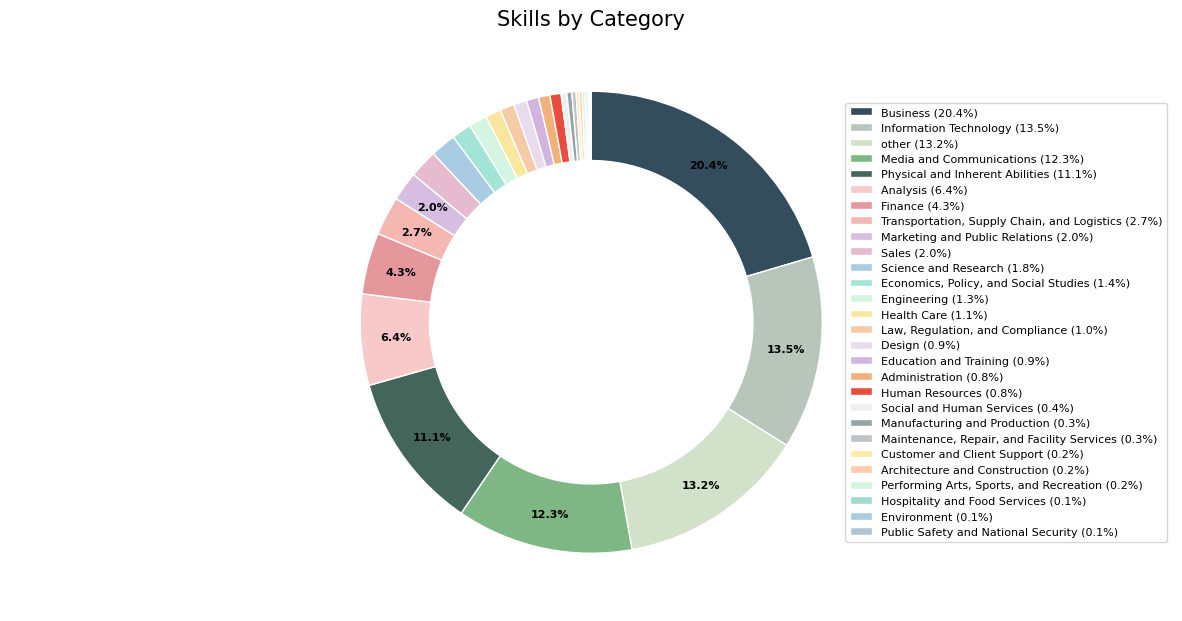

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate total number of skills
total_skills = sum(skills_per_category.values())

# Define colours
colors = ['#334d5c', '#b7c5bb', '#d1e1ca', '#7fb685', '#43655a', '#f7cac9', '#e5989b', '#f5b7b1', '#d7bde2', '#e6bbcf',
          '#a9cce3', '#a3e4d7', '#d5f5e3', '#f9e79f', '#f5cba7', '#e8daef', '#d2b4de', '#f0b27a', '#e74c3c', '#ecf0f1',
          '#95a5a6', '#bdc3c7', '#ffeaa7', '#ffcdab', '#d5f5e3', '#a2d9ce', '#a9cce3', '#aec6cf', '#e6b0aa', '#d7bde2',
          '#c39bd3', '#f1948a', '#f7dc6f', '#f0e68c', '#c8b487', '#b6b6b6', '#f9c74f', '#90e0ef', '#a7c5eb', '#d8e2dc',
          '#ffe8d6', '#ffbdbd', '#ffb6c1', '#e59866', '#f5d7b5', '#fbeee6', '#eaffd0', '#d4ebd3', '#add8e6', '#c9c9ff',
          '#ffdead', '#e6e6e6', '#fff1e6', '#f0fff0', '#e6e6fa', '#f08080', '#ff69b4', '#fa8072', '#ffc0cb', '#ff6347',
          '#d1ccc0', '#ff7f50', '#ffb347', '#ffdab9', '#8c7ae6', '#f5e6ca', '#ffefd5', '#b19cd9', '#7f8c8d', '#f8c291',
          '#f6ddcc', '#dfe6e9', '#00cec9', '#ffda79', '#ff6b6b', '#95afc0', '#ffeaa7', '#b8e994', '#78e08f', '#60a3bc',
          '#f6e58d', '#ff9ff3', '#341f97', '#ffbe76', '#e55039', '#70a1ff', '#a29bfe', '#fab1a0', '#ff9f43', '#ff6b81',
          '#badc58', '#e056fd', '#686de0', '#4834d4', '#ffbe0b', '#ff7979', '#6ab04c', '#eb4d4b', '#1e272e', '#8c7ae6']

# Create Pie Chart
sorted_values = sorted(skills_per_category.values(), reverse=True)
sorted_categories = [list(skills_per_category.keys())[list(skills_per_category.values()).index(v)] for v in sorted_values]
fig, ax = plt.subplots(figsize=(15,7.5))
ax.axis('equal')
pie = ax.pie(sorted_values, colors=colors, startangle=90, counterclock=False, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

# Add inner circle
circle = plt.Circle((0,0), 0.7, color='white')
fig.gca().add_artist(circle)

# Add labels and percentages
labels = []
categories = []
for i, category in enumerate(sorted_categories):
    count = skills_per_category[category]
    percentage = count/total_skills*100
    if round(percentage, 1) > 0:
      if category not in categories:
        labels.append(f"{category} ({percentage:.1f}%)")
      categories.append(category)
    if percentage >= 2:
        angle = pie[0][i].theta1 + 0.5 * (pie[0][i].theta2 - pie[0][i].theta1)
        x = np.cos(np.deg2rad(angle))
        y = np.sin(np.deg2rad(angle))
        plt.text(x*0.85, y*0.85, f"{percentage:.1f}%", ha='center', va='center', fontsize=8, fontweight='bold')

# Add legend       
plt.legend(pie[0], labels, loc="right", fontsize=8)

# Set title
plt.title('Skills by Category', fontsize=15)

# Show diagram
plt.show()

4.5 Plot skills per Subcategory

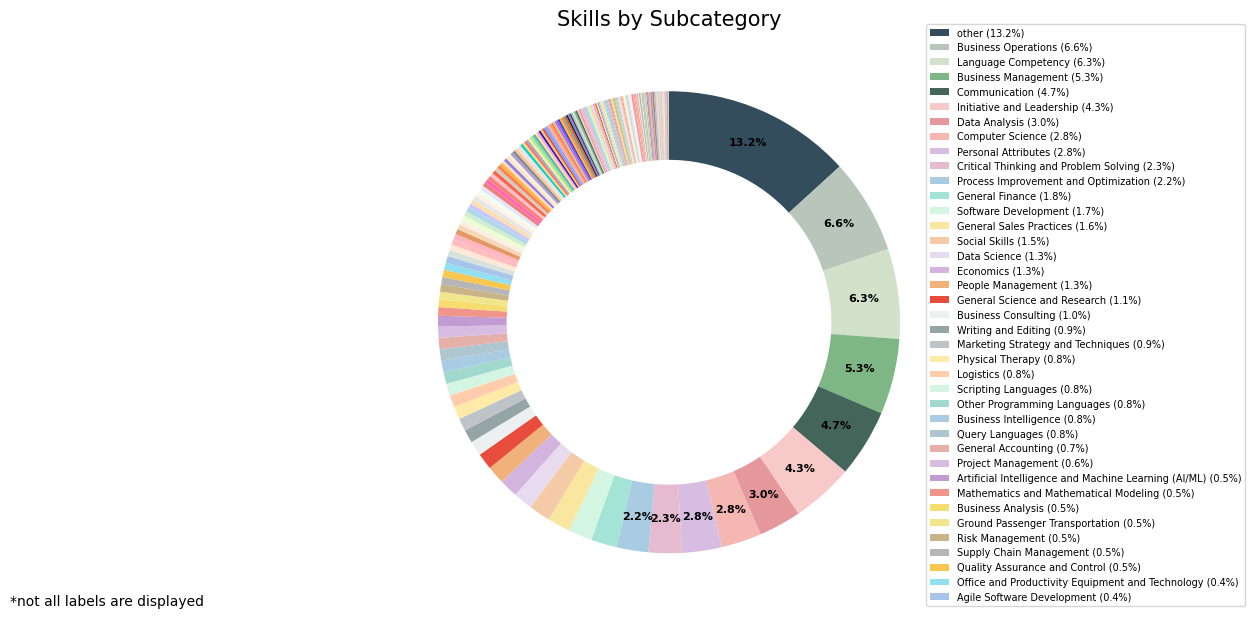

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate total number of skills
total_skills = sum(skills_per_sub_category.values())

# Define colours
colors = ['#334d5c', '#b7c5bb', '#d1e1ca', '#7fb685', '#43655a', '#f7cac9', '#e5989b', '#f5b7b1', '#d7bde2', '#e6bbcf',
          '#a9cce3', '#a3e4d7', '#d5f5e3', '#f9e79f', '#f5cba7', '#e8daef', '#d2b4de', '#f0b27a', '#e74c3c', '#ecf0f1',
          '#95a5a6', '#bdc3c7', '#ffeaa7', '#ffcdab', '#d5f5e3', '#a2d9ce', '#a9cce3', '#aec6cf', '#e6b0aa', '#d7bde2',
          '#c39bd3', '#f1948a', '#f7dc6f', '#f0e68c', '#c8b487', '#b6b6b6', '#f9c74f', '#90e0ef', '#a7c5eb', '#d8e2dc',
          '#ffe8d6', '#ffbdbd', '#ffb6c1', '#e59866', '#f5d7b5', '#fbeee6', '#eaffd0', '#d4ebd3', '#add8e6', '#c9c9ff',
          '#ffdead', '#e6e6e6', '#fff1e6', '#f0fff0', '#e6e6fa', '#f08080', '#ff69b4', '#fa8072', '#ffc0cb', '#ff6347',
          '#d1ccc0', '#ff7f50', '#ffb347', '#ffdab9', '#8c7ae6', '#f5e6ca', '#ffefd5', '#b19cd9', '#7f8c8d', '#f8c291',
          '#f6ddcc', '#dfe6e9', '#00cec9', '#ffda79', '#ff6b6b', '#95afc0', '#ffeaa7', '#b8e994', '#78e08f', '#60a3bc',
          '#f6e58d', '#ff9ff3', '#341f97', '#ffbe76', '#e55039', '#70a1ff', '#a29bfe', '#fab1a0', '#ff9f43', '#ff6b81',
          '#badc58', '#e056fd', '#686de0', '#4834d4', '#ffbe0b', '#ff7979', '#6ab04c', '#eb4d4b', '#1e272e', '#8c7ae6']


# Create Pie Chart
sorted_values = sorted(skills_per_sub_category.values(), reverse=True)
sorted_subcategories = [list(skills_per_sub_category.keys())[list(skills_per_sub_category.values()).index(v)] for v in sorted_values]
fig, ax = plt.subplots(figsize=(15,7.5))
ax.axis('equal')
pie = ax.pie(sorted_values, colors=colors, startangle=90, counterclock=False, wedgeprops={'linewidth': 0, 'edgecolor': 'white'})

# Add inner circle
circle = plt.Circle((0,0), 0.7, color='white')
fig.gca().add_artist(circle)

# Add labels and percentages
labels = []
categories = []

for i, category in enumerate(sorted_subcategories):
    count = skills_per_sub_category[category]
    percentage = count/total_skills*100
    if percentage >= 0.4:
      if category not in categories:
        labels.append(f"{category} ({percentage:.1f}%)")
    categories.append(category)
    if percentage >= 2:
        angle = pie[0][i].theta1 + 0.5 * (pie[0][i].theta2 - pie[0][i].theta1)
        x = np.cos(np.deg2rad(angle))
        y = np.sin(np.deg2rad(angle))
        plt.text(x*0.85, y*0.85, f"{percentage:.1f}%", ha='center', va='center', fontsize=8, fontweight='bold')

# Add legend
plt.legend(pie[0], labels, loc="lower right", fontsize=7)

# Set title
plt.title('Skills by Subcategory', fontsize=15)
text = '*not all labels are displayed'
plt.text(0.10, 0.005, text, ha='right', va='bottom', transform=plt.gca().transAxes)

# Show diagram
plt.show()

4.6 Percentage share of categories in all identified skills over time


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

# X-axis
years = np.array(list(token_freqs.keys()))

# Dict to store the number of skills per category for each year
skills_per_category_by_year = {}
skills_per_sub_category_by_year = {}

# Store the number of skills per category for each year
for year in token_freqs.keys():

  skills_per_category_by_year[year] = {}
  skills_per_sub_category_by_year[year] = {}

  # Adjusting some key values to match Api skills
  for i, tup in enumerate(token_freqs[year]):
    if tup[0] == 'communications':
        token_freqs_overall[i] = ('communication', tup[1])
    if tup[0] == 'bpmn':
        token_freqs_overall[i] = ('business_process_management', tup[1])
    if tup[0] == 'bpm':
        token_freqs_overall[i] = ('business_process_management', tup[1])

  # Assigning skills to categories, counting skill per category
  for token, freq in token_freqs[year]:
    # Assigning category if skill is in skill_dict
    if token in skills_dict:
      category = skills_dict[token]['category']
      if skills_dict[token]['category'] == 'none':
        category = 'other'
    else:
      category = 'other'
    if category not in skills_per_category_by_year[year]:
      skills_per_category_by_year[year][category] = freq
    else:
      skills_per_category_by_year[year][category] += freq

# Number of skills per year
number_of_skills_per_year = {}
for year in token_freqs:
  number_of_skills = 0
  for skill, count in token_freqs[year]:
    number_of_skills += count
  number_of_skills_per_year[year] = number_of_skills

# List to store categories
categories = []
for token in skills_per_category:
  categories.append(token)

# Dict to store value for each category in each year
categories_per_year = {}

# Calculate percentage for each categorie in each year
for category in categories:
  for year in skills_per_category_by_year:
    value = 0
    for term, count in skills_per_category_by_year[year].items():
      if term == category:
        value = count/number_of_skills_per_year[year]
        break
    if category in categories_per_year:
      categories_per_year[category].append(value)
    else:
      categories_per_year[category] = []
      categories_per_year[category].append(value)

# Create a checkbox list for the categories
categories_list = list(filter_duplicates_keep_order(sorted_categories))
categories_checkboxes = widgets.SelectMultiple(
    options=categories_list,
    value=[categories_list[0]],  # Default value for the output selection
    rows=10,
    description='Categories:',
    disabled=False,
    layout=widgets.Layout(height='150px')
)

# Create plot function
def plot_categories(categories):
    plt.clf() # delete current plot

    fig = plt.figure(figsize=(10,5))
    fig, ax = plt.subplots(figsize=(10,5))
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

    # Create line for each selected category
    for category in categories:
        plt.plot(years, np.array(categories_per_year[category]), label=category)

    # Set the x-axis ticks to correspond to the year values
    ax.set_xticks(years)

    # Label axes
    plt.xlabel("Year")
    plt.ylabel("Share of all skills found")

    # Add title
    plt.title("The Evolution of Job Requirements in various Skill Categories Over Time", fontsize=16)

    # Add legend
    plt.legend()
    plt.show()

# Link checkbox list with plot function
widgets.interactive(plot_categories, categories=categories_checkboxes)

interactive(children=(SelectMultiple(description='Categories:', index=(0,), layout=Layout(height='150px'), opt…

4.7 Percentage share of subcategories in all identified skills over time

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

# X-axis
years = np.array(list(token_freqs.keys()))

# Dict to store the number of skills per subategory for each year
skills_per_sub_category_by_year = {}

# Store the number of skills per subcategory for each year
for year in token_freqs.keys():

  skills_per_sub_category_by_year[year] = {}

  # Adjusting some key values
  for i, tup in enumerate(token_freqs[year]):
    if tup[0] == 'communications':
        token_freqs_overall[i] = ('communication', tup[1])
    if tup[0] == 'bpmn':
        token_freqs_overall[i] = ('business_process_management', tup[1])
    if tup[0] == 'bpm':
        token_freqs_overall[i] = ('business_process_management', tup[1])


  # Assigning skills to subcategories, counting skill per subcategory
  for token, freq in token_freqs[year]:
    # Assigning subcategory if skill is in skill_dict
    if token in skills_dict:
      subcategory = skills_dict[token]['subcategory']
      if skills_dict[token]['subcategory'] == 'none':
        subcategory = 'other'
    else:
      subcategory = 'other'
    if subcategory not in skills_per_sub_category_by_year [year]:
      skills_per_sub_category_by_year [year][subcategory] = freq
    else:
      skills_per_sub_category_by_year [year][subcategory] += freq

# Number of skills per year
number_of_skills_per_year = {}
for year in token_freqs:
  number_of_skills = 0
  for skill, count in token_freqs[year]:
    number_of_skills += count
  number_of_skills_per_year[year] = number_of_skills

# List to store categories
sub_categories = []
for token in skills_per_sub_category:
  sub_categories.append(token)

# Dict to store value for each category in each year
sub_categories_per_year = {}

# Calculate percentage for each subcategorie in each year
for category in sub_categories:
  for year in skills_per_sub_category_by_year :
    value = 0
    for term, count in skills_per_sub_category_by_year [year].items():
      if term == category:
        value = count/number_of_skills_per_year[year]
        break
    if category in sub_categories_per_year:
      sub_categories_per_year[category].append(value)
    else:
      sub_categories_per_year[category] = []
      sub_categories_per_year[category].append(value)

# Create a checkbox list for subcategories
sub_categories_list = list(filter_duplicates_keep_order(sorted_subcategories))
sub_categories_checkboxes = widgets.SelectMultiple(
    options=sub_categories_list,
    value=[sub_categories_list[0]],  # Default value for the output selection
    rows=10,
    description='Subcategories:',
    disabled=False,
    layout=widgets.Layout(height='150px')
)

# Create plot function
def plot_sub_categories(sub_categories):
    plt.clf() # delete current plot

    fig = plt.figure(figsize=(14,6))
    fig, ax = plt.subplots(figsize=(14,6))
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

    # Create line for each selected subcategory
    for sub_category in sub_categories:
        plt.plot(years, np.array(sub_categories_per_year[sub_category]), label=sub_category)

    # Set the x-axis ticks to correspond to the year values
    ax.set_xticks(years)

    # Label axes
    plt.xlabel("Year")
    plt.ylabel("Share of all skills found")

    # Add title
    plt.title("The Evolution of Job Requirements in various Skill Subcategories Over Time", fontsize=16)

    # Add legend
    plt.legend()
    plt.show()

# Link checkbox list with plot function
widgets.interactive(plot_sub_categories, sub_categories=sub_categories_checkboxes)

interactive(children=(SelectMultiple(description='Subcategories:', index=(0,), layout=Layout(height='150px'), …

# 5. Evaluation

5.1 Evaluation of lda model for different nummber of topics

In [38]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Lists for storing coherence and perplexity values
coherence_values = []
coherence_values_cv = []
coherence = []
perplexity_values = []

for num_topics in range(1, 100, 1):

    # Create a dictionary representation of the documents
    dictionary = Dictionary(filtered_docs_all)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents (currently switched off)
    #dictionary.filter_extremes(no_below=5)

    # Bag-of-words representation of the documents
    corpus = [dictionary.doc2bow(doc) for doc in filtered_docs_all]

    # Set training parameters
    chunksize = 2000 # Sets the number of documents used in each chunk during training to avoid memory issues
    passes = 10 # Sets the number of training passes to improve the model accuracy
    iterations = 100 # Sets the maximum number of iterations during the inference process for each document, which determines the accuracy of the model

    # Make an index to word dictionary
    temp = dictionary[0]  # Used only to "load" the dictionary
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes
    )

    #########################COHERENCE############################
    # Calculation of coherence with the c_v coherence model
    coherence_model_cv = CoherenceModel(model=model, texts=filtered_docs_all, dictionary=dictionary, coherence='c_v')
    coherence_cv = coherence_model_cv.get_coherence()
    coherence_values_cv.append(coherence_model_cv.get_coherence())
    print(("Number of Topics: " + str(num_topics) + " -> Coherence (c_v): " + str(coherence_cv)))

    # Calculation of coherence with the u_mass coherence model
    coherence_model_u_mass = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
    coherence_values.append(("Anzahl der Topics: " + str(num_topics) + " -> Coherence: " + str(coherence_model_u_mass.get_coherence())))
    coherence.append(coherence_model_u_mass.get_coherence())

    ########################PERPLEXITY###########################

    # Get the perplexity score
    perplexity = model.log_perplexity(corpus)
    perplexity_values.append("Anzahl der Topics: " + str(num_topics) + " -> Perplexity: " + str(perplexity))
    print("Anzahl der Topics: " + str(num_topics) + " -> Perplexity: " + str(perplexity))

Number of Topics: 1 -> Coherence (c_v): 0.31286771606043573
Anzahl der Topics: 1 -> Perplexity: -5.749724150564979


Number of Topics: 2 -> Coherence (c_v): 0.379678161716025
Anzahl der Topics: 2 -> Perplexity: -5.602349083569716


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-0d415a9ec313>", line 31, in <cell line: 11>
    model = LdaModel(
  File "/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py", line 521, in __init__
    self.update(corpus, chunks_as_numpy=use_numpy)
  File "/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py", line 1006, in update
    gammat = self.do_estep(chunk, other)
  File "/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py", line 768, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py", line 720, in inference
    Elogthetad = dirichlet_expectation(gammad)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
 

TypeError: ignored

5.2 Coherence score (u_mass)

In [ ]:
import matplotlib.pyplot as plt

# Set parameters
limit = 100
start = 1
step = 1
x = range(start, limit, step)

# Set color
color = '#334d5c'

fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(figsize=(10,5))

# Find the lowest coherence value
min_coherence = min(coherence)

# Find the index of the lowest y-value
index_min_y = np.argmin(coherence)

# Access the corresponding x-value with the found index
x_min_y = x[index_min_y]

# Plot the coherence line and line for the lowest value
plt.plot(x, coherence, color=color, label='coherence (u_mass)')
plt.axvline(x=x_min_y, color=color, linestyle='--')

# Add text for best coherence value
best_coherence_text = "Best coherence score \nfor " + f"{x_min_y:.0f} topics (" + f"{min_coherence:.2f})"
plt.text(x_min_y + 2, -6, best_coherence_text, fontsize=12, color=color, rotation='horizontal')

# Add labels and show plot
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Coherence score (u_mass) for different number of topics", fontsize=16)
plt.legend()
plt.show()

5.3 Coherence score (c_v)

In [ ]:
import matplotlib.pyplot as plt

# Set parameters
limit = 100
start = 1
step = 1
x = range(start, limit, step)

# Set color
color = '#334d5c'

fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(figsize=(10,5))

# Find the lowest coherence value
max_coherence = min(coherence_values_cv)

# Find the index of the lowest y-value
index_min_y = np.argmax(coherence_values_cv)

# Access the corresponding x-value with the found index
x_min_y = x[index_min_y]

# Plot the coherence line and line for the lowest value
plt.plot(x, coherence_values_cv, color=color, label='coherence (c_v)')
plt.axvline(x=x_min_y, color=color, linestyle='--')

# Add text for best coherence value
best_coherence_text = "Best coherence score \nfor " + f"{x_min_y:.0f} topics (" + f"{max_coherence:.2f})"
plt.text(x_min_y + 2, 0.34, best_coherence_text, fontsize=12, color=color, rotation='horizontal')

# Add labels and show plot
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Coherence score (c_v) for different number of topics", fontsize=16)
plt.legend()
plt.show()